## Script to plot CMIP6 future temperature and precip over N and S Ghana

Author: Jess Baker (j.c.baker@leeds.ac.uk)

In [2]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import cf_units
import pandas as pd
import copy
import climate_indices
from climate_indices import compute, indices
import iris
from netCDF4 import date2num
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
import os 


def cube_to_frame(cube_dict, expt='hist', constraint=None, convert_units=None): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value'])
    
    for key in cube_dict.keys():
        cube = cube_dict[key].copy()
        
        if convert_units is not None:
            cube.convert_units(units)
        
        cube = cube.extract(constraint) # constrain over area of Ghana
        
        cube_time_mean = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
                
        model = key #extract from attributes later
        
        x = cube_time_mean.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        iris.coord_categorisation.add_year(cube_time_mean, 'time', name='year')
        iris.coord_categorisation.add_month(cube_time_mean, 'time', name='month')
        
        year =  cube_time_mean.coord('year').points
        #print(year)
        month = cube_time_mean.coord('month').points
        
        y = pd.DataFrame(columns =   ['model', 'expt', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['model'] = model
        y['expt'] = expt
        y['month'] = month
        
        df= df.append(y)
    
    return(df)

### Run the next cell if you wish to perform the calculation. If already calculated and saved output then you can jump to the next cell

In [3]:
# get area means of temp and precip for all future scenarios
assert False
df_dict = {}
path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/spei_output/'
unit_list = ['kg m-2 month-1', 'Celsius']
labels = ['P_all', 'P_North', 'P_South', 'T_all', 'T_North', 'T_South']

time_constraint = iris.Constraint(time=lambda cell: 1980 <= cell.point.year <= 2100)

for expt in ['ssp119', 'ssp126', 'ssp245', 'ssp585']:
        
    pr_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_pr_dict.npy').item()
    tas_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_tas_dict.npy').item()
    
    all_constraint = None
    n_constraint = iris.Constraint(latitude = lambda cell: cell >= 8.0)
    s_constraint = iris.Constraint(latitude = lambda cell: cell <= 8.0)

    constraints = [all_constraint, n_constraint, s_constraint]
   
    label_counter = 0
    clim_counter = 0
    
    for clim_dict in [pr_datasets, tas_datasets]:

        for n in range(3):

            constraint = constraints[n] & time_constraint
            units = unit_list[clim_counter]
            df = cube_to_frame(clim_dict, expt=expt, constraint=constraint, convert_units=units)
            print(expt + '_' + labels[label_counter])
            print(df.head(3))

            df_dict[expt + '_' + labels[label_counter]] = df
            label_counter += 1
            
        clim_counter += 1

    #assert False
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
np.save(outpath + 'area_mean_clim_data_ghana_dict.npy', df_dict)

AssertionError: 

In [4]:
# load dictionary saved in previous cell
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
df_dict = np.load(path + 'area_mean_clim_data_ghana_dict.npy').item()

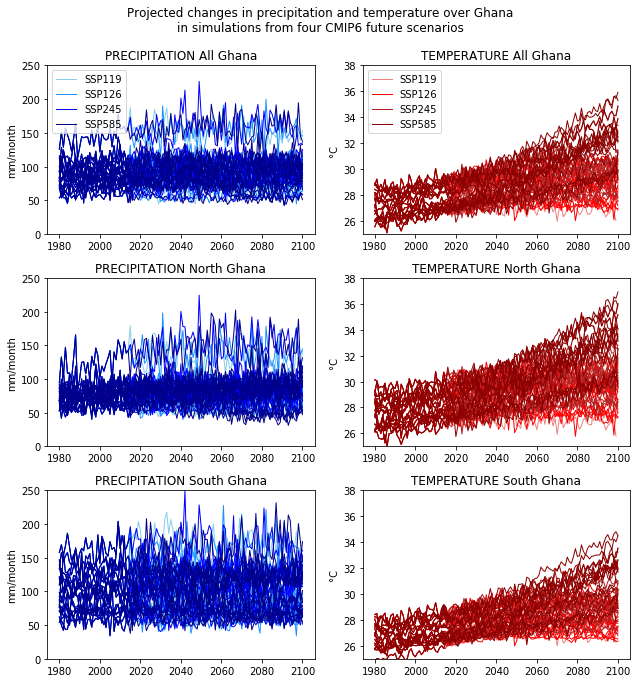

In [5]:
blue_colours = ['skyblue', 'dodgerblue', 'blue', 'darkblue']
red_colours = ['lightcoral', 'red', 'firebrick', 'darkred']
col_list = [blue_colours, red_colours]

p_labels = ['P_all', 'P_North', 'P_South']
t_labels = ['T_all', 'T_North', 'T_South']
labels = [p_labels, t_labels]
variables = ['PRECIPITATION', 'TEMPERATURE']
titles = [' All Ghana', ' North Ghana', ' South Ghana']
expts = ['ssp119', 'ssp126', 'ssp245', 'ssp585']
ylims = [(0,250), (25, 38)]
units = ['mm/month', '°C']
colcounter = 0

fig = plt.figure(figsize = (9,9))

# loop over all, north and south Ghana
subplots = [1, 3, 5, 2, 4, 6]
subplot = 0
for i in range(2):
    colors = col_list[i]
    for n in range(3):
        ax = fig.add_subplot(3, 2, subplots[subplot])
        subplot += 1

        #loop over expts
        colcounter = 0
        lines = []
        for expt in expts:
            col = colors[colcounter]
            colcounter += 1

            # get labels
            labels_temp = labels[i]
            label = labels_temp[n]
            df_label = expt + '_' + label
            df = df_dict[df_label]
            
            model_counter = 0
            for model in np.unique(df['model'])[0:]:

                model_df = df[df.model==model]

                # group df by year
                model_df = model_df.groupby(['year'])['value'].agg(lambda x: x.unique().mean())
                
                years =  np.unique(model_df.index)
                
                if n == 0 and model_counter == 0:
                    lines += ax.plot(years, model_df, lw=1, color=col)
                    #print('COUNTING LINES')
                    model_counter += 1
                else:
                    ax.plot(years, model_df, lw=1, color=col)
        ax.set_title(variables[i] + titles[n]) 
        ax.set_ylabel(units[i])
        ax.set_ylim(ylims[i])
        if n == 0:
            ax.legend(lines, [x.upper() for x in expts], loc =2, ncol = 1, frameon = True)
    
plt.suptitle('Projected changes in precipitation and temperature over Ghana\nin simulations from four CMIP6 future scenarios', y=1.05)
plt.tight_layout()
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/future_trends_precip_and_temp_over_ghana.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')

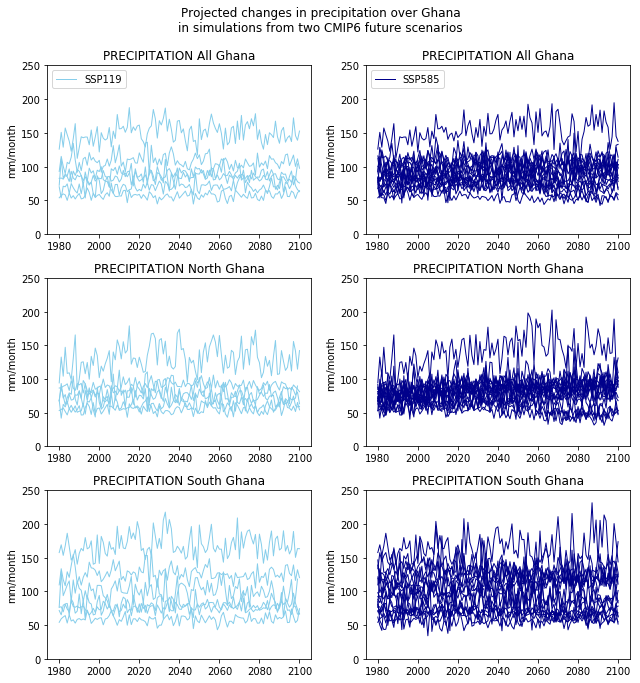

In [7]:
# Plot precip data only for SSP119 and SSP585

blue_colours = ['skyblue', 'darkblue']
p_labels = ['P_all', 'P_North', 'P_South']
t_labels = ['T_all', 'T_North', 'T_South']
labels = [p_labels, t_labels]
titles = [' All Ghana', ' North Ghana', ' South Ghana']
expts = ['ssp119', 'ssp585']
ylims = [(0,250), (25, 38)]
units = ['mm/month', '°C']
colcounter = 0

fig = plt.figure(figsize = (9,9))

# loop over all, north and south
subplots = [1, 3, 5, 2, 4, 6]
subplot = 0
     
colcounter = 0
for expt in expts:
    colors = blue_colours
    col = colors[colcounter]
    colcounter += 1
    lines = []
    for n in range(3):  
        
        ax = fig.add_subplot(3, 2, subplots[subplot])
        subplot += 1

        # get labels
        labels_temp = p_labels
        label = labels_temp[n]
        df_label = expt + '_' + label
        df = df_dict[df_label]

        model_counter = 0
        for model in np.unique(df['model'])[0:]:

            model_df = df[df.model==model]

            # group df by year
            model_df = model_df.groupby(['year'])['value'].agg(lambda x: x.unique().mean())

            years =  np.unique(model_df.index)

            if n == 0 and model_counter == 0:
                lines += ax.plot(years, model_df, lw=1, color=col)
                #print('COUNTING LINES')
                model_counter += 1
            else:
                ax.plot(years, model_df, lw=1, color=col)
        ax.set_title(variables[0] + titles[n]) 
        ax.set_ylabel(units[0])
        ax.set_ylim(ylims[0])
        if n == 0:
            ax.legend(lines, [expt.upper()], loc =2, ncol = 1, frameon = True)
    
plt.suptitle('Projected changes in precipitation over Ghana\nin simulations from two CMIP6 future scenarios', y=1.05)
plt.tight_layout()
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/future_trends_precip_over_ghana_two_scenarios.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')

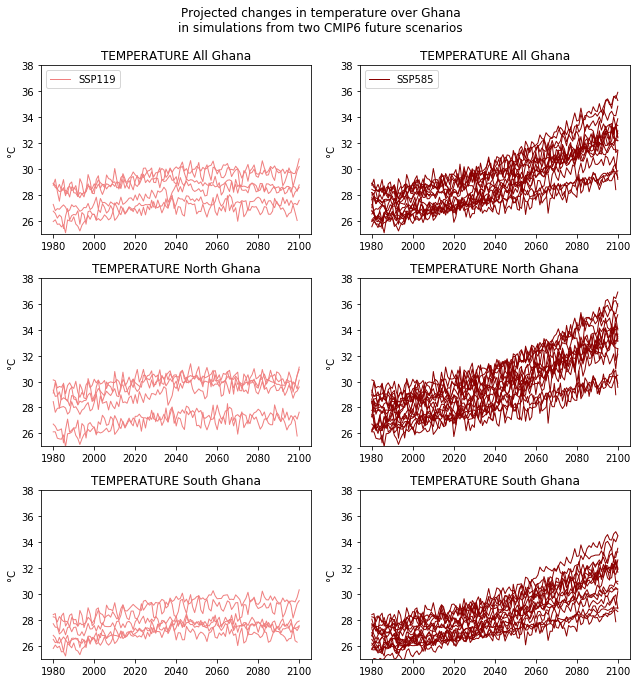

In [8]:
# Plot temperature data only for SSP119 and SSP585
red_colours = ['lightcoral', 'darkred']

t_labels = ['T_all', 'T_North', 'T_South']
labels = [p_labels, t_labels]
titles = [' All Ghana', ' North Ghana', ' South Ghana']
expts = ['ssp119', 'ssp585']
ylims = [(0,250), (25, 38)]
units = ['mm/month', '°C']
colcounter = 0

fig = plt.figure(figsize = (9,9))

# loop over all, north and south
subplots = [1, 3, 5, 2, 4, 6]
subplot = 0
     
colcounter = 0
for expt in expts:
    colors = red_colours
    col = colors[colcounter]
    colcounter += 1
    lines = []
    for n in range(3):  
        
        ax = fig.add_subplot(3, 2, subplots[subplot])
        subplot += 1

        # get labels
        labels_temp = t_labels
        label = labels_temp[n]
        df_label = expt + '_' + label
        df = df_dict[df_label]

        model_counter = 0
        for model in np.unique(df['model'])[0:]:

            model_df = df[df.model==model]

            # group df by year
            model_df = model_df.groupby(['year'])['value'].agg(lambda x: x.unique().mean())

            years =  np.unique(model_df.index)

            if n == 0 and model_counter == 0:
                lines += ax.plot(years, model_df, lw=1, color=col)
                #print('COUNTING LINES')
                model_counter += 1
            else:
                ax.plot(years, model_df, lw=1, color=col)
        ax.set_title(variables[1] + titles[n]) 
        ax.set_ylabel(units[1])
        ax.set_ylim(ylims[1])
        if n == 0:
            ax.legend(lines, [expt.upper()], loc =2, ncol = 1, frameon = True)
    
plt.suptitle('Projected changes in temperature over Ghana\nin simulations from two CMIP6 future scenarios', y=1.05)
plt.tight_layout()
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/future_trends_temp_over_ghana_two_scenarios.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')

In [9]:
# Get historical, mid century and end of century T and P values averaged over all available models

ssp_119_n_p = df_dict['ssp119_P_North']
ssp_119_s_p = df_dict['ssp119_P_South']

ssp_119_n_t = df_dict['ssp119_T_North']
ssp_119_s_t = df_dict['ssp119_T_South']

ssp_585_n_p = df_dict['ssp585_P_North']
ssp_585_s_p = df_dict['ssp585_P_South']

ssp_585_n_t = df_dict['ssp585_T_North']
ssp_585_s_t = df_dict['ssp585_T_South']

ssp_245_n_t = df_dict['ssp245_T_North']
ssp_245_s_t = df_dict['ssp245_T_South']

hist_n_p =  ssp_119_n_p[(ssp_119_n_p.year<=2010)].value.mean()
hist_s_p =  ssp_119_s_p[(ssp_119_s_p.year<=2010)].value.mean()

ssp119_n_mid_p = ssp_119_n_p[(ssp_119_n_p.year>=2040)&(ssp_119_n_p.year<2050)].value.mean()
ssp119_s_mid_p = ssp_119_s_p[(ssp_119_s_p.year>=2040)&(ssp_119_s_p.year<2050)].value.mean()

ssp119_n_late_p = ssp_119_n_p[(ssp_119_n_p.year>=2090)&(ssp_119_n_p.year<2100)].value.mean()
ssp119_s_late_p = ssp_119_s_p[(ssp_119_s_p.year>=2090)&(ssp_119_s_p.year<2100)].value.mean()

ssp585_n_mid_p = ssp_585_n_p[(ssp_585_n_p.year>=2040)&(ssp_585_n_p.year<2050)].value.mean()
ssp585_s_mid_p = ssp_585_s_p[(ssp_585_s_p.year>=2040)&(ssp_585_s_p.year<2050)].value.mean()

ssp585_n_late_p = ssp_585_n_p[(ssp_585_n_p.year>=2090)&(ssp_585_n_p.year<2100)].value.mean()
ssp585_s_late_p = ssp_585_s_p[(ssp_585_s_p.year>=2090)&(ssp_585_s_p.year<2100)].value.mean()

hist_n_t =  ssp_119_n_t[(ssp_119_n_t.year<=2010)].value.mean()
hist_s_t =  ssp_119_s_t[(ssp_119_s_t.year<=2010)].value.mean()

ssp119_n_mid_t = ssp_119_n_t[(ssp_119_n_t.year>=2040)&(ssp_119_n_t.year<2050)].value.mean()
ssp119_s_mid_t = ssp_119_s_t[(ssp_119_s_t.year>=2040)&(ssp_119_s_t.year<2050)].value.mean()

ssp119_n_late_t = ssp_119_n_t[(ssp_119_n_t.year>=2090)&(ssp_119_n_t.year<2100)].value.mean()
ssp119_s_late_t = ssp_119_s_p[(ssp_119_s_t.year>=2090)&(ssp_119_s_t.year<2100)].value.mean()

ssp585_n_mid_t = ssp_585_n_t[(ssp_585_n_t.year>=2040)&(ssp_585_n_t.year<2050)].value.mean()
ssp585_s_mid_t = ssp_585_s_t[(ssp_585_s_t.year>=2040)&(ssp_585_s_t.year<2050)].value.mean()

ssp585_n_late_t = ssp_585_n_t[(ssp_585_n_t.year>=2090)&(ssp_585_n_t.year<2100)].value.mean()
ssp585_s_late_t = ssp_585_s_t[(ssp_585_s_t.year>=2090)&(ssp_585_s_t.year<2100)].value.mean()

ssp245_n_mid_t = ssp_245_n_t[(ssp_245_n_t.year>=2040)&(ssp_245_n_t.year<2050)].value.mean()
ssp245_s_mid_t = ssp_245_s_t[(ssp_245_s_t.year>=2040)&(ssp_245_s_t.year<2050)].value.mean()

80.15382601208556
100.53976200220266
28.068166952159785
27.124093479808252
